Урок 1. Введение в спортивный анализ данных, Exploration Data Analysis.

Домашнее задание 1:  
Задание 1: Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;  
Задание 2: Сделать базовый анализ целевой переменной, сделать выводы;  
Задание 3: Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;  
Задание 4: Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;  
Задание 5: Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?  
Задание 6: Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.  
Задание 7 (опция): Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.  
Ссылка на наборы данных: https://drive.google.com/file/d/1j8zuKbI-PW5qKwhybP4S0EtugbPqmeyX/view?usp=sharing  
p.s. это обязательная программа для выполнения домашки, вы можете расширить эту программу и сделать больше; я только за :)  

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm
import matplotlib as mpl
plt.savefig("High resoltion.png",dpi=600)
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno

<Figure size 432x288 with 0 Axes>

In [ ]:
!unzip /content/drive/MyDrive/assignment1_data.zip

Archive:  /content/drive/MyDrive/assignment1_data.zip
  inflating: test.csv                
  inflating: __MACOSX/._test.csv     
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    


In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 308.23 MB
Memory usage after optimization is: 154.30 MB
Decreased by 49.9%


In [ ]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 306.70 MB
Memory usage after optimization is: 154.11 MB
Decreased by 49.8%


In [ ]:
# выберем только числовые признаки
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 201


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

Задание 1

In [ ]:
stata = pd.DataFrame(columns=['train', 'test'])

In [ ]:
def basic_analysis(data, data_name):
    
    stata.loc['Количество наблюдений', data_name] = data.shape[0]
    stata.loc['Количество признаков', data_name] = data.shape[1]
    
    dict_dtypes = {}
    for i in data.dtypes.unique():
        dict_dtypes[i] = 0
    for j in data.dtypes:
        dict_dtypes[j] += 1  
    for k, v in dict_dtypes.items():
        stata.loc[f'Признаков {k}', data_name] = v
        
    list_nan = 0
    for i in data.count():
        if i != data.shape[0]:
            list_nan += 1
    stata.loc[f'Признаков с NaN', data_name] = list_nan
    
    list_disc = 0
    list_cont = 0
    for i in data.columns:
        if data[i].dtype != object:
            if data[i].nunique() < 25:
                list_disc += 1
            else:
                list_cont += 1          
    stata.loc[f'Дискретных признаков', data_name] = list_disc
    stata.loc[f'Непрерывных признаков', data_name] = list_cont
    
    dict_num = {'единицы': 0, 'десятки': 0, 'прочее': 0}
    for i in data.columns:
        if data[i].dtype != object:
            num = len(str(round(abs(max(data[i])))))
            if num == 1:
                dict_num['единицы'] += 1
            elif num == 2:
                dict_num['десятки'] += 1
            else:
                dict_num['прочее'] += 1
    for k, v in dict_num.items():
        stata.loc[f'Масштаб признаков в {k}', data_name] = v

In [ ]:
basic_analysis(data=train, data_name='train')
basic_analysis(data=test, data_name='test')

In [ ]:
train.info

<bound method DataFrame.info of              ID_code  target    var_0  ...  var_197    var_198  var_199
0            train_0       0   8.9255  ...   8.5635  12.780300  -1.0914
1            train_1       0  11.5006  ...   8.7889  18.356001   1.9518
2            train_2       0   8.6093  ...   8.2675  14.722200   0.3965
3            train_3       0  11.0604  ...  10.2922  17.969700  -8.9996
4            train_4       0   9.8369  ...   9.5031  17.997400  -8.8104
...              ...     ...      ...  ...      ...        ...      ...
199995  train_199995       0  11.4880  ...   8.5326  16.666000 -17.8661
199996  train_199996       0   4.9149  ...   6.7419  15.905400   0.3388
199997  train_199997       0  11.2232  ...   8.7155  13.832900   4.1995
199998  train_199998       0   9.7148  ...  10.0342  15.528900 -13.9001
199999  train_199999       0  10.8762  ...   8.1857  12.128400   0.1385

[200000 rows x 202 columns]>

In [ ]:
train.head()

ID_code  target    var_0   var_1  ...  var_196  var_197    var_198  var_199
0  train_0       0   8.9255 -6.7863  ...   7.8784   8.5635  12.780300  -1.0914
1  train_1       0  11.5006 -4.1473  ...   8.1267   8.7889  18.356001   1.9518
2  train_2       0   8.6093 -2.7457  ...  -6.5213   8.2675  14.722200   0.3965
3  train_3       0  11.0604 -2.1518  ...  -2.9275  10.2922  17.969700  -8.9996
4  train_4       0   9.8369 -1.4834  ...   3.9267   9.5031  17.997400  -8.8104

[5 rows x 202 columns]

In [ ]:
test.info

<bound method DataFrame.info of             ID_code    var_0    var_1  ...  var_197    var_198    var_199
0            test_0  11.0656   7.7798  ...  10.7200  15.472200  -8.719700
1            test_1   8.5304   1.2543  ...   9.8714  19.129299 -20.976000
2            test_2   5.4827 -10.3581  ...   7.0618  19.895599 -23.179399
3            test_3   8.5374  -1.3222  ...   9.2295  13.016800  -4.210800
4            test_4  11.7058  -0.1327  ...   7.2882  13.926000  -9.184600
...             ...      ...      ...  ...      ...        ...        ...
199995  test_199995  13.1678   1.0136  ...   9.1568  18.210199   4.880100
199996  test_199996   9.7171  -9.1462  ...   9.1112  18.174000 -20.768900
199997  test_199997  11.6360   2.2769  ...   9.1933  11.790500 -22.276199
199998  test_199998  13.5745  -0.5134  ...   8.1079   8.773500  -0.212200
199999  test_199999  10.4664   1.8070  ...  10.3378  14.334000  -7.709400

[200000 rows x 201 columns]>

In [ ]:
test.head()

ID_code    var_0    var_1    var_2  ...  var_196  var_197    var_198    var_199
0  test_0  11.0656   7.7798  12.9536  ...   4.3654  10.7200  15.472200  -8.719700
1  test_1   8.5304   1.2543  11.3047  ...  -1.4852   9.8714  19.129299 -20.976000
2  test_2   5.4827 -10.3581  10.1407  ...  -7.1086   7.0618  19.895599 -23.179399
3  test_3   8.5374  -1.3222  12.0220  ...   3.9567   9.2295  13.016800  -4.210800
4  test_4  11.7058  -0.1327  14.1295  ...  -5.1612   7.2882  13.926000  -9.184600

[5 rows x 201 columns]

In [ ]:
train.describe()

target          var_0  ...        var_198        var_199
count  200000.000000  200000.000000  ...  200000.000000  200000.000000
mean        0.100490      10.679973  ...      15.870864      -3.326542
std         0.300653       3.039990  ...       3.010892      10.437832
min         0.000000       0.408400  ...       6.299300     -38.852798
25%         0.000000       8.453850  ...      13.829700     -11.208475
50%         0.000000      10.524750  ...      15.934050      -2.819550
75%         0.000000      12.758200  ...      18.064724       4.836800
max         1.000000      20.315001  ...      26.079100      28.500700

[8 rows x 201 columns]

In [ ]:
test.describe()

var_0          var_1  ...        var_198        var_199
count  200000.000000  200000.000000  ...  200000.000000  200000.000000
mean       10.658732      -1.624240  ...      15.869393      -3.246347
std         3.036675       4.040431  ...       3.008664      10.398454
min         0.188700     -15.043400  ...       6.584000     -39.457802
25%         8.442975      -4.700125  ...      13.847275     -11.124000
50%        10.513800      -1.590500  ...      15.943400      -2.725950
75%        12.739600       1.343400  ...      18.045200       4.935400
max        22.323400       9.385100  ...      26.538401      27.907400

[8 rows x 200 columns]

In [ ]:
stata

train    test
Количество наблюдений        200000  200000
Количество признаков            202     201
Признаков object                  1       1
Признаков int8                    1     NaN
Признаков float32               200     200
Признаков с NaN                   0       0
Дискретных признаков              1       0
Непрерывных признаков           200     200
Масштаб признаков в единицы      30      31
Масштаб признаков в десятки     171     169
Масштаб признаков в прочее        0       0


Вывод:  
- ID_code - не несет смысловой нагрузки
- датасеты одинаковые по размеру (без учета целевой переменной в train)  
- числовые признаки относятся к непрерывным, масштаб достаточно однородный   

Задание 2

In [ ]:
target_name = 'target'
cont_feature_name = list(train.select_dtypes(include=[np.float32]).columns)

In [ ]:
train[target_name].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [ ]:
disbalance = round(train[target_name].value_counts()[0] / train[target_name].value_counts()[1], 2)
disbalance

8.95


Вывод:  
целевая переменная состоит из 0 и 1 - задаче бинарной классификации.  
дисбаланс классов целевой переменной составляет 1:9, существует возможность переобучения. 

Задание 3

In [ ]:
test_feature_name = ['var_0', 'var_1', 'var_2', 'var_5', 'var_9', 'var_10', 'var_13', 'var_20', 'var_26',
                     'var_40', 'var_55', 'var_80', 'var_106', 'var_109', 'var_139', 'var_175', 'var_184', 'var_196']
# features = test_feature_name
features = cont_feature_name

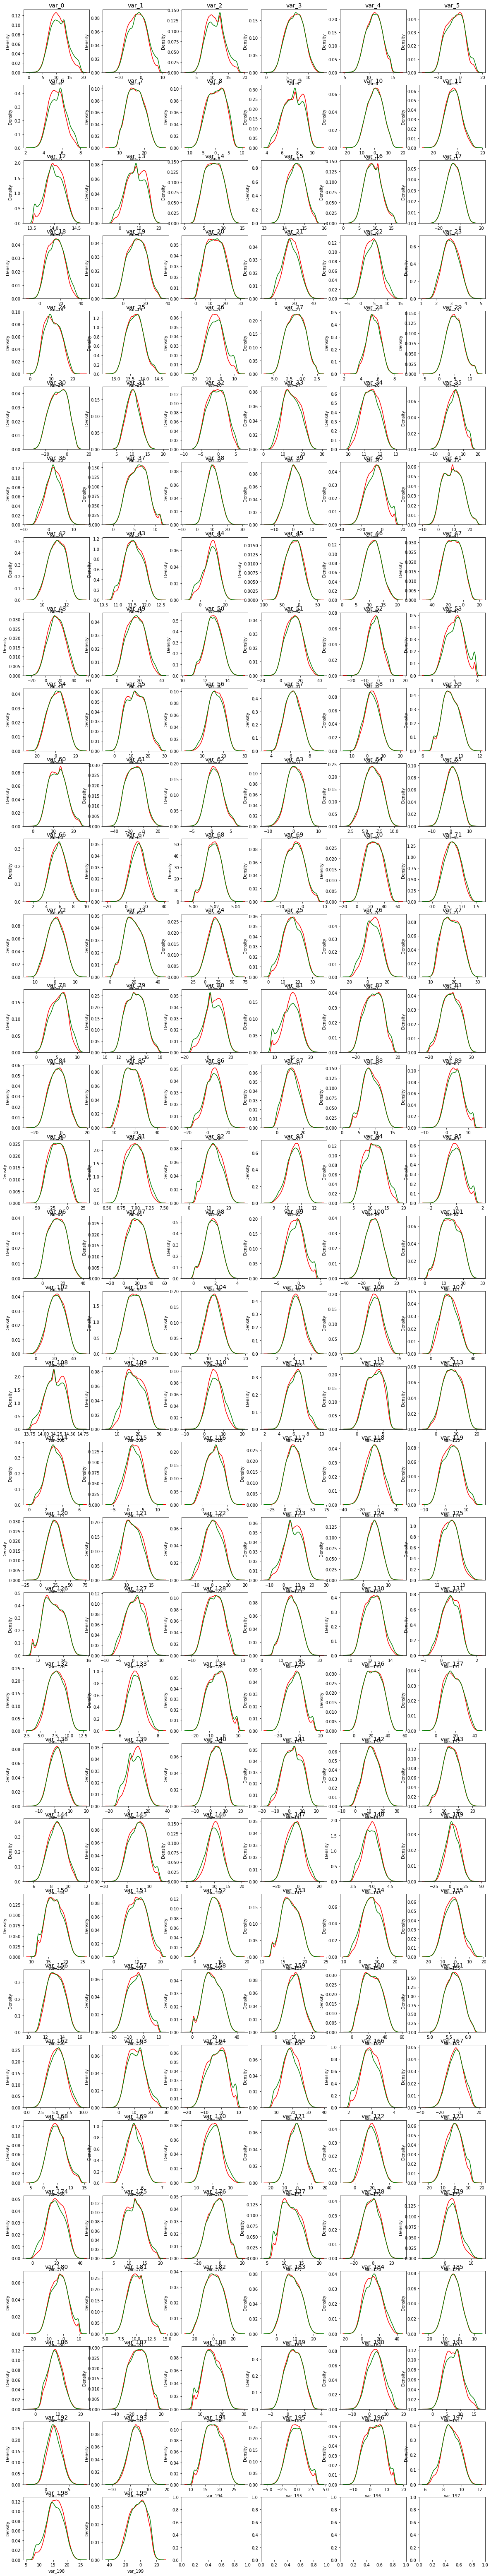

CPU times: user 5min 17s, sys: 2min 12s, total: 7min 29s
Wall time: 5min 5s


In [ ]:
%%time

cols = 6
x = len(features)/cols
rows = round(x if int(x) == x else (x) + 0.5)

fig, axes = plt.subplots(rows, cols, figsize=(20, (20/cols)*rows))

for num, feature in enumerate(features):
    limit_bal_with_target = train[[feature, target_name]]
    limit_bal = limit_bal_with_target[feature]
    limit_bal_target_0 = limit_bal[limit_bal_with_target[target_name] == 0]
    limit_bal_target_1 = limit_bal[limit_bal_with_target[target_name] == 1]

    sns.kdeplot(limit_bal_target_0, ax=axes[num//cols, num%cols], label='0', color='r')
    sns.kdeplot(limit_bal_target_1, ax=axes[num//cols, num%cols], label='1', color='g')
    axes[num//cols, num%cols].set_title(feature, fontsize=14)

plt.show()

Вывод:  
Есть признаки, которые имеют различные распределения в зависимости от значения целевой переменной

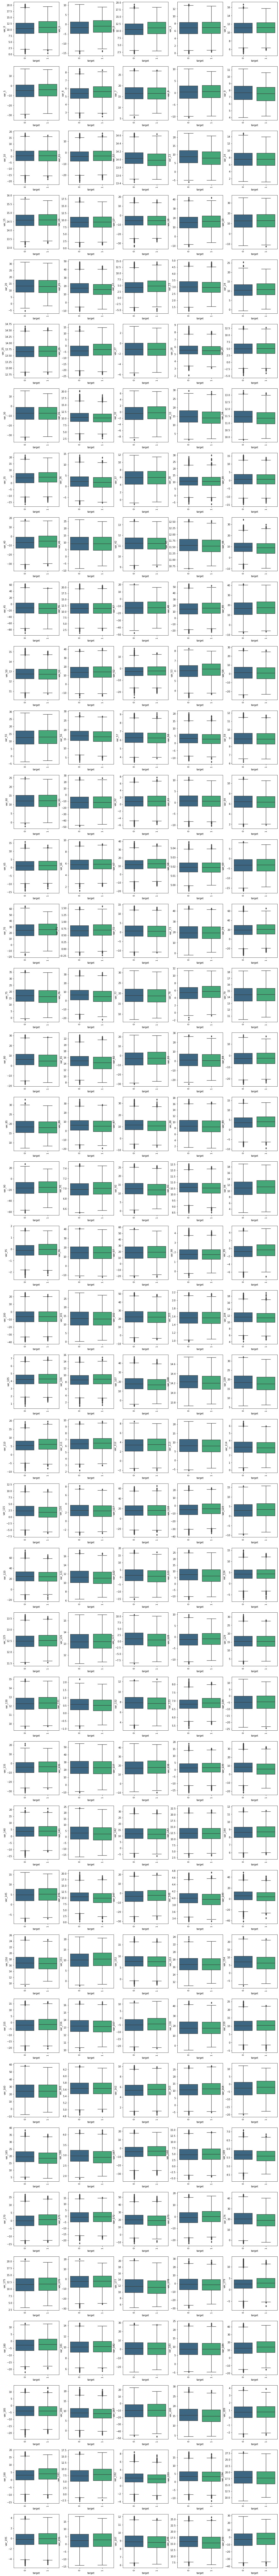

In [ ]:
features = list(train.columns)[2:]
row_no, column_no = 40, 5
fig, axes = plt.subplots(row_no, column_no, figsize=(20, 200))
#targert = train[TARGET_NAME].copy()

for num, feature in enumerate(features):
    data = train[feature].copy()
    sns.boxplot(y=feature, x='target', data=train, palette="viridis", ax=axes[num//column_no, num%column_no]) 
    axes[num//column_no, num%column_no].tick_params(axis="x", rotation=90)

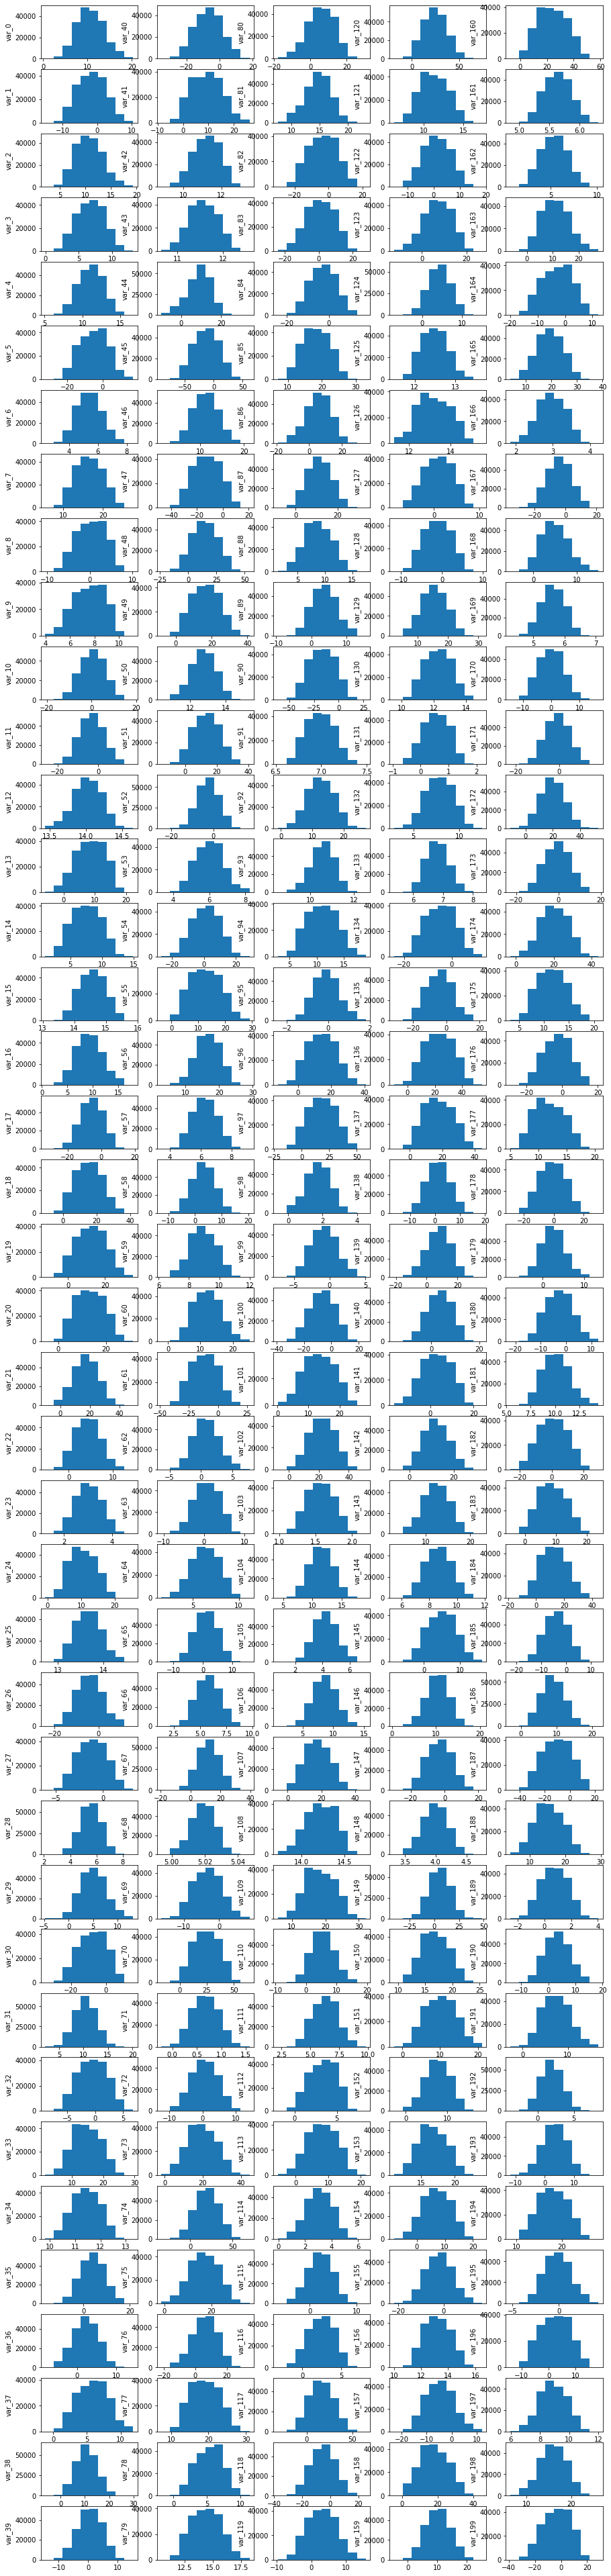

In [ ]:
fig, axes = plt.subplots(nrows=40, ncols=5, figsize=(15, 70))
for num, i in enumerate(train.columns.to_list()[2:]):
    axes[num%40, num//40].hist(train[i])
    axes[num%40, num//40].set_ylabel(i)

Вывод:  
рапределение признаков схоже и близко к нормальному

Задание 4

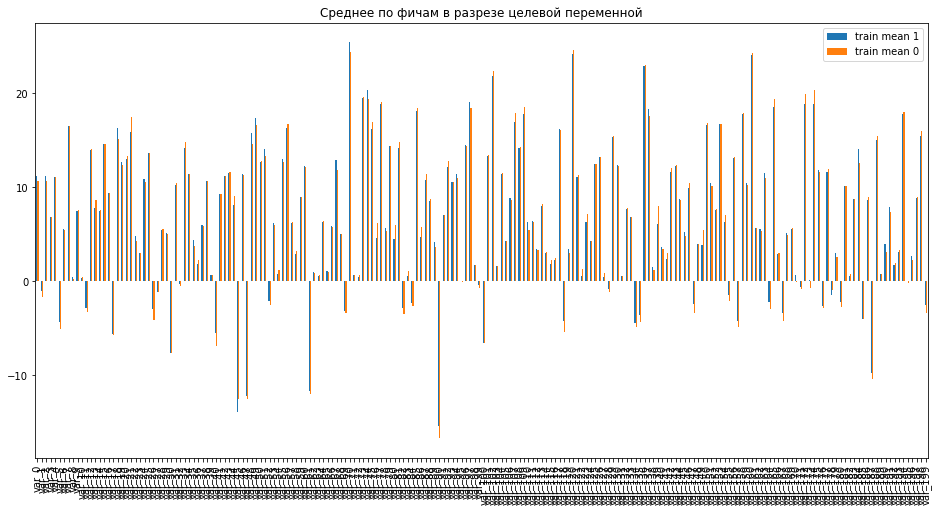

In [ ]:
df = pd.DataFrame({
    # среднее по всем фичам трейна за исключением таргета
    'train mean 1': train.loc[train['target']==1, :].describe().iloc[1,1:],
    # среднее по всем фичам теста (здесь таргета нет)
    'train mean 0': train.loc[train['target']==0, :].describe().iloc[1,1:]
})

df.plot.bar(figsize=(16,8))
plt.title('Среднее по фичам в разрезе целевой переменной');

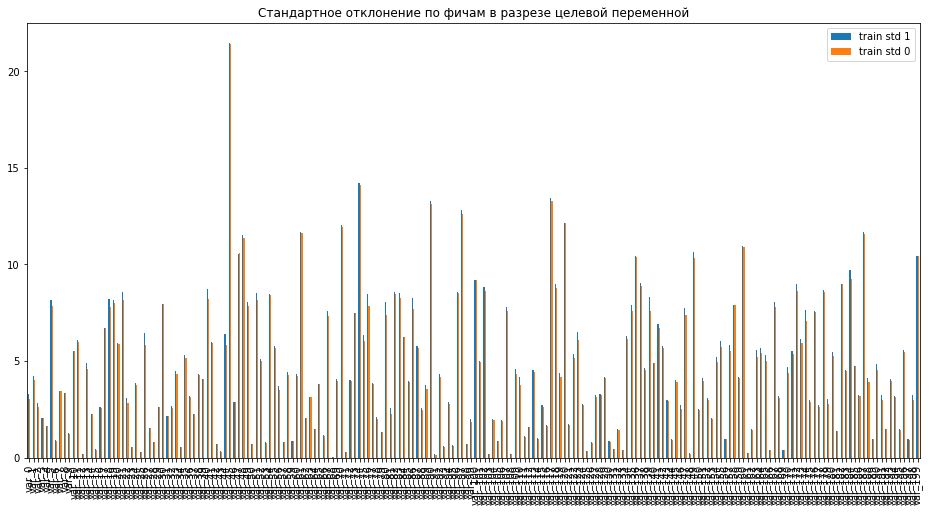

In [ ]:
df = pd.DataFrame({
    # среднее по всем фичам трейна за исключением таргета
    'train std 1': train.loc[train['target']==1, :].describe().iloc[2,1:],
    # среднее по всем фичам теста (здесь таргета нет)
    'train std 0': train.loc[train['target']==0, :].describe().iloc[2,1:]
})

df.plot.bar(figsize=(16,8))
plt.title('Стандартное отклонение по фичам в разрезе целевой переменной');

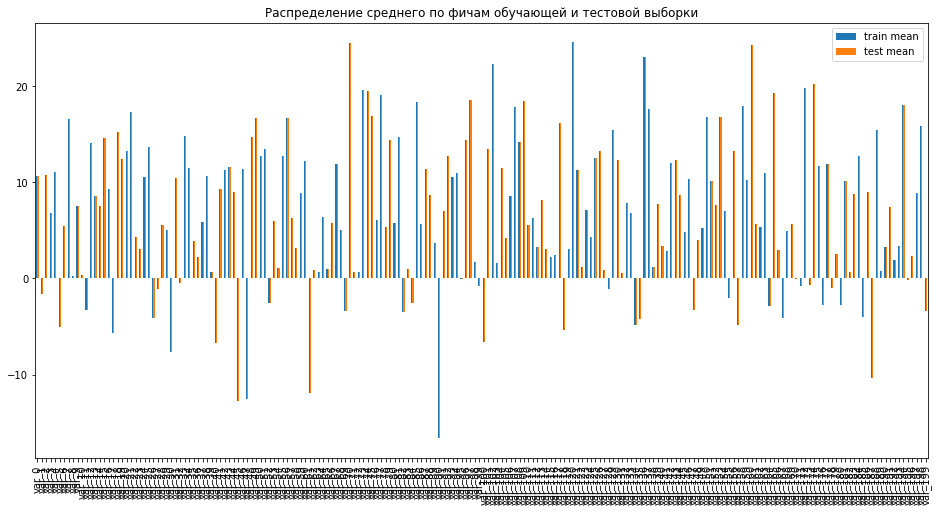

In [ ]:
df = pd.DataFrame({
    # среднее по всем фичам трейна за исключением таргета
    'train mean': train.describe().iloc[1,1:],
    # среднее по всем фичам теста (здесь таргета нет)
    'test mean': train.describe().iloc[1,1:]
})

df.plot.bar(figsize=(16,8))
plt.title('Распределение среднего по фичам обучающей и тестовой выборки');

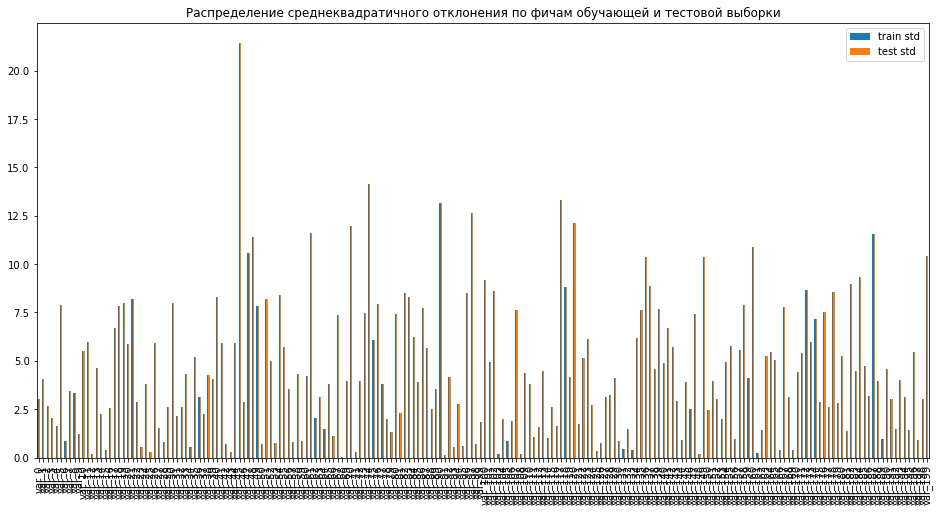

In [ ]:
df = pd.DataFrame({
    # среднее по всем фичам трейна за исключением таргета
    'train std': train.describe().iloc[2,1:],
    # среднее по всем фичам теста (здесь таргета нет)
    'test std': train.describe().iloc[2,1:]
})

df.plot.bar(figsize=(16,8))
plt.title('Распределение среднеквадратичного отклонения по фичам обучающей и тестовой выборки');

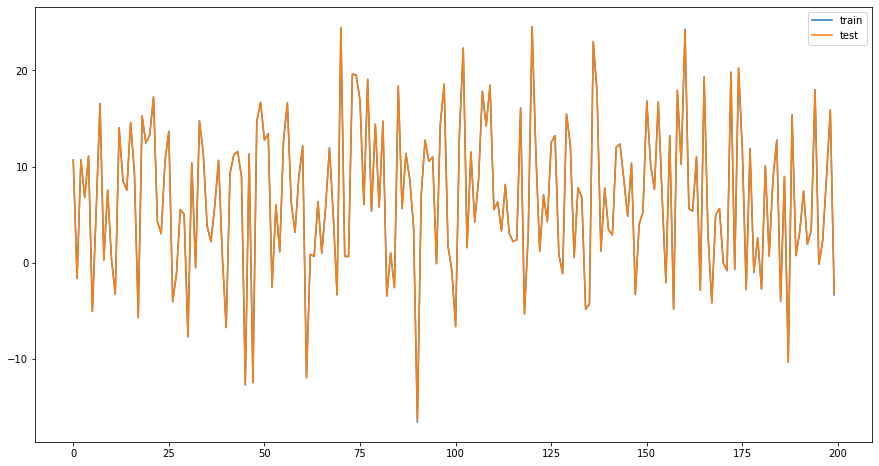

In [ ]:
# Средняя по признакам на тесте и на трйне
plt.figure(figsize=(15,8))
tr = train.describe()
t=test.describe()
plt.plot(list(range(len(tr.columns)-1)),tr.loc['mean'].to_list()[1:],label = 'train')
plt.plot(list(range(len(t.columns))),t.loc['mean'].to_list(), label = 'test')
plt.legend()

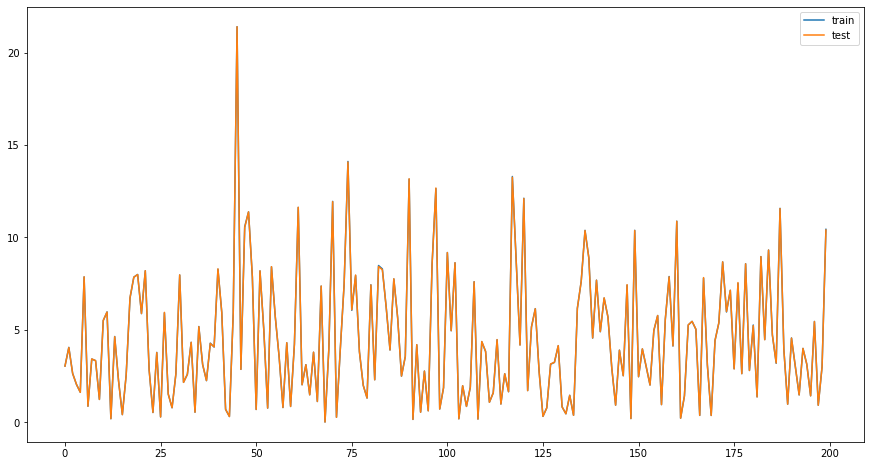

In [ ]:
# std по признакам на тесте и на трйне
plt.figure(figsize=(15,8))
plt.plot(list(range(len(tr.columns)-1)),tr.loc['std'].to_list()[1:],label = 'train')
plt.plot(list(range(len(t.columns))),t.loc['std'].to_list(), label = 'test')
plt.legend()

train и test в точнгсти совпадают по mean и std

In [ ]:
tr_1 = train[train['target']==1].describe()
tr_0 = train[train['target']==0].describe()

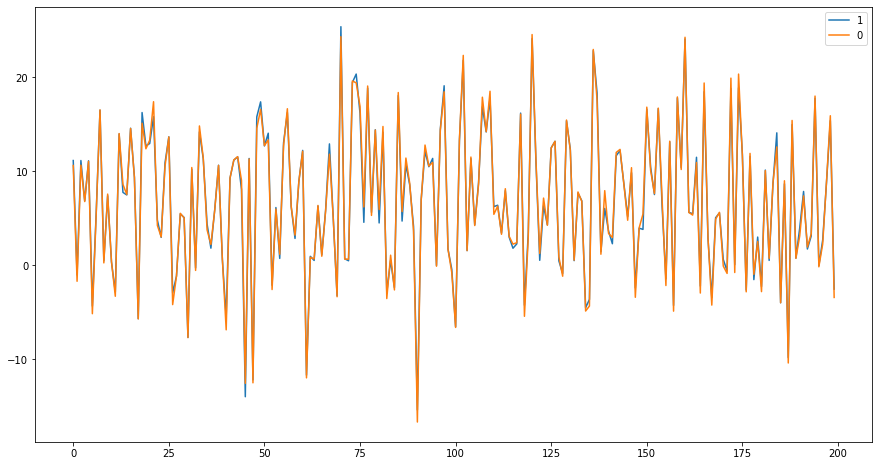

In [ ]:
# Средняя по признакам на целевой переменной
plt.figure(figsize=(15,8))
plt.plot(list(range(len(tr_1.columns)-1)),tr_1.loc['mean'].to_list()[1:],label = '1')
plt.plot(list(range(len(tr_0.columns)-1)),tr_0.loc['mean'].to_list()[1:], label = '0')
plt.legend()

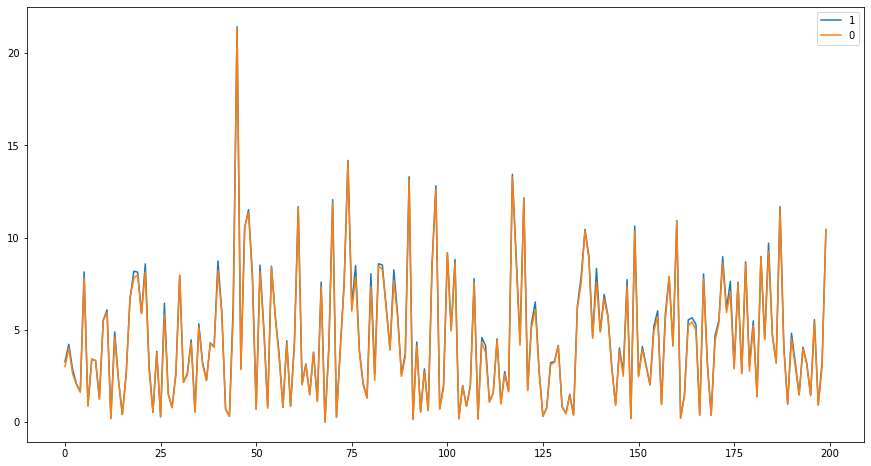

In [ ]:
# std по признакам на целевой переменной
plt.figure(figsize=(15,8))
plt.plot(list(range(len(tr_1.columns)-1)),tr_1.loc['std'].to_list()[1:],label = '1')
plt.plot(list(range(len(tr_0.columns)-1)),tr_0.loc['std'].to_list()[1:], label = '0')
plt.legend()

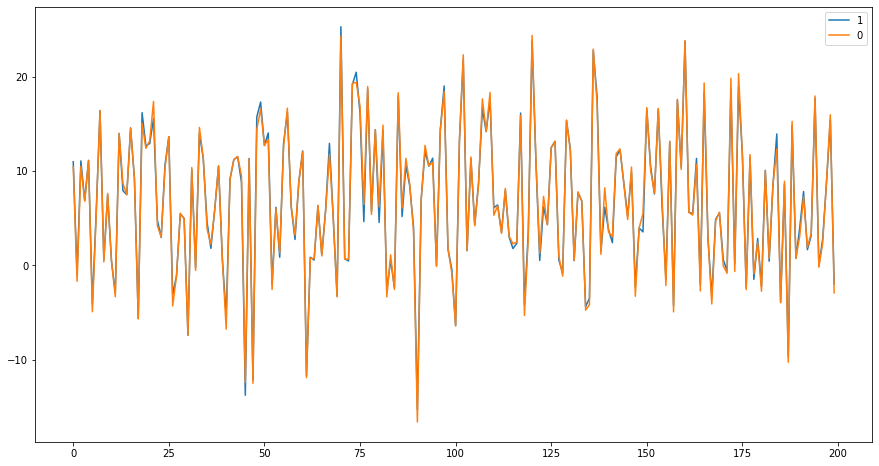

In [ ]:
# медиана по признакам на целевой переменной
plt.figure(figsize=(15,8))
plt.plot(list(range(len(tr_1.columns)-1)),tr_1.loc['50%'].to_list()[1:],label = '1')
plt.plot(list(range(len(tr_0.columns)-1)),tr_0.loc['50%'].to_list()[1:], label = '0')
plt.legend()

Распределения основных статистик выборок схожи.

Задание 5

In [ ]:
correlation = train.corr()

In [ ]:
flag = True
for i in correlation:
    d = correlation[(correlation[i]>0.2)&(correlation[i]<1)][i]
    if len(d)>0:
        print(d)
        flag=False
if flag:
    print('Нет признаков с корреляцией более 0,2')

Нет признаков с корреляцией более 0,2


Text(0, 0.5, 'Density')

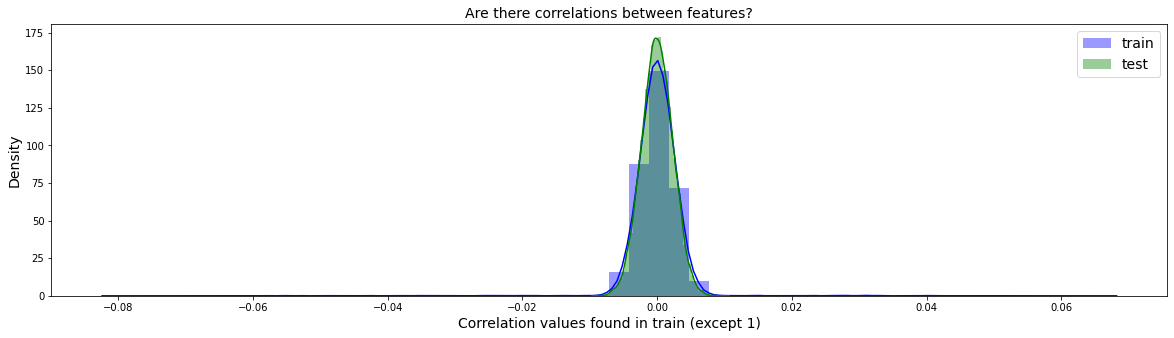

In [ ]:
train_correlations = train.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = numerical_features.columns.tolist()
columns.remove("target")

test_correlations = test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

Выделяются 5 признаков с максимальной коррелицией.

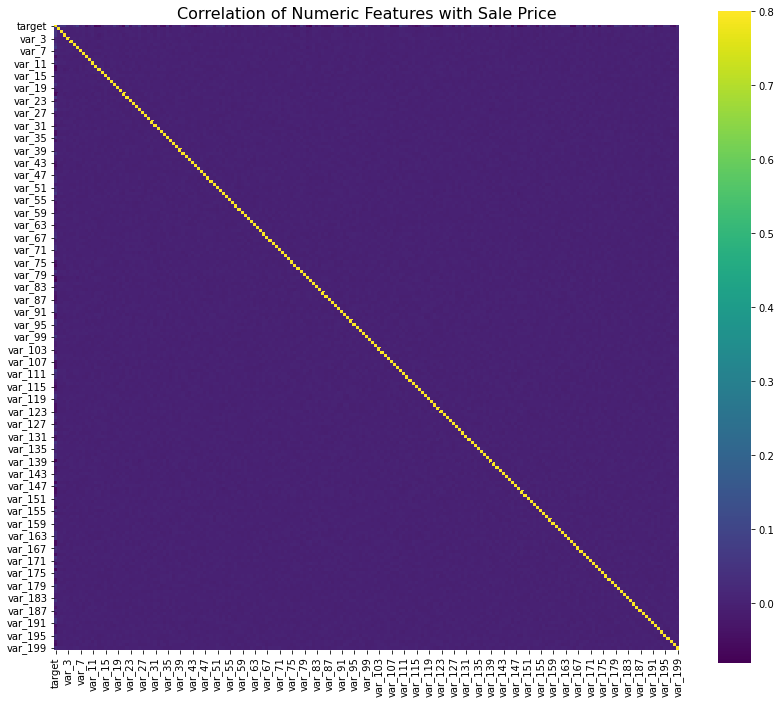

In [ ]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

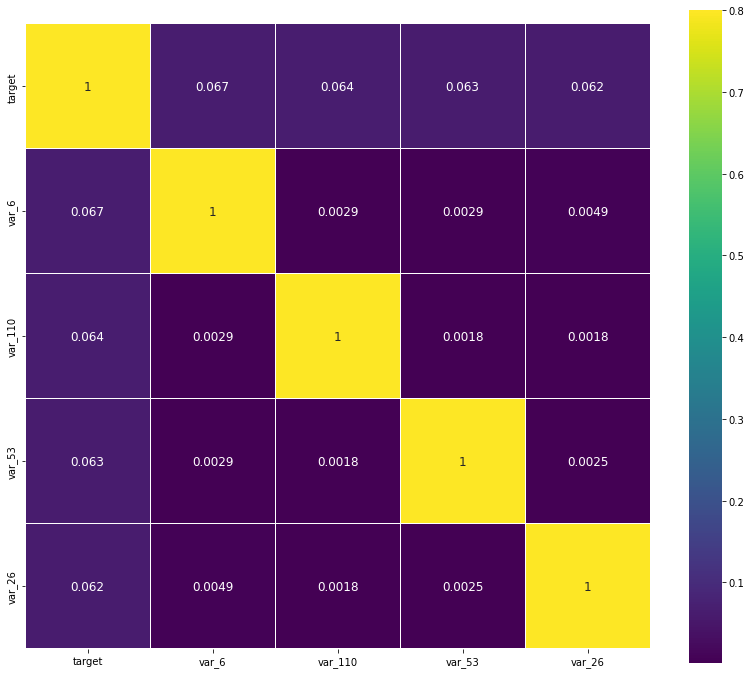

In [ ]:
k = 5
cols = correlation.nlargest(k, "target")["target"].index
cm = np.corrcoef(train[cols].values.T)
fig, axes = plt.subplots(figsize = (14, 12))

sns.heatmap(
    cm,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=cols.values,
    annot_kws = {"size": 12},
    yticklabels=cols.values
)

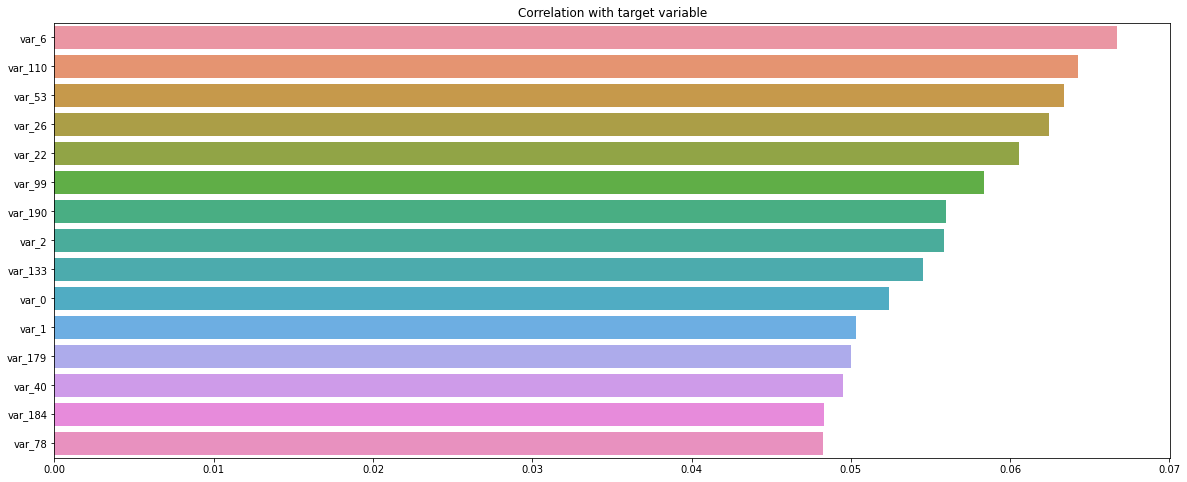

CPU times: user 17.1 s, sys: 28.1 ms, total: 17.1 s
Wall time: 17 s


In [ ]:
%%time

top = 15
corr_with_target = train[features + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)
corr_with_target = corr_with_target.head(n=top)

plt.figure(figsize=(20, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Вывод:
- нет линейной зависимости  
- низкая корреляция признаков с целевой переменной

Задание 6

In [ ]:
%%time

parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)
forest.fit(train[features], train['target'])

CPU times: user 8min 44s, sys: 32.9 ms, total: 8min 44s
Wall time: 4min 31s


Text(0.5, 1.0, 'What are the top important features to start with?')

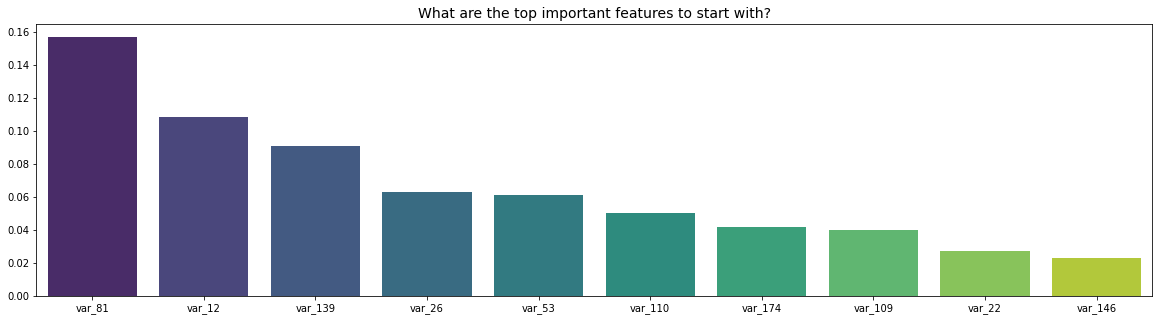

In [ ]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = train[features].columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

Задание 7

In [ ]:
X_adv = pd.concat([
    train[features], test[features]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [ ]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5099
CPU times: user 12min 40s, sys: 1.2 s, total: 12min 42s
Wall time: 6min 22s


Вывод:  
метрика roc_auc близка к 0,5 - объекты выбороки из одного распределения. 